In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
from single_photons.utils.constants import *
from single_photons.environment import Particle

In [2]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [89]:
import numpy as np


class KalmanFilter:
     
    def __init__(self,x0,P0,A,B,C,Q,R):
        '''
          x0 - initial guess of the state vector 
         P0 - initial guess of the covariance matrix of the state estimation error
         A,B,C - system matrices describing the system model
         Q - covariance matrix of the process noise 
         R - covariance matrix of the measurement noise
        '''    
        self.x0=x0
        self.P0=P0
        self.A=A
        self.B=B
        self.C=C
        self.Q=Q
        self.R=R
        self.t_i=0
        self.estimates_aposteriori = [x0]
        self.estimates_apriori = []    
        self.error_covariance_aposteriori = [P0]
        self.error_covariance_apriori = []
        self.gainMatrices=[]
        self.errors=[]
         
    def propagate_dynamics(self,inputValue):
         
        xk_minus=self.A*self.estimates_aposteriori[self.t_i]+self.B*inputValue
        Pk_minus=self.A*self.error_covariance_aposteriori[self.t_i]*(self.A.T)+self.Q
        self.estimates_apriori.append(xk_minus)
        self.error_covariance_apriori.append(Pk_minus)         
        self.t_i=self.t_i+1
     
    def compute_aposteriori(self,currentMeasurement):
        Kk=self.error_covariance_apriori[self.t_i-1]*(self.C.T)*np.linalg.pinv(self.R+self.C*self.error_covariance_apriori[self.t_i-1]*(self.C.T))
        error_k=currentMeasurement-self.C*self.estimates_apriori[self.t_i-1]
        xk_plus=self.estimates_apriori[self.t_i-1]+Kk*error_k
        IminusKkC=np.matrix(np.eye(self.x0.shape[0]))-Kk*self.C
        Pk_plus=IminusKkC*self.error_covariance_apriori[self.t_i-1]*(IminusKkC.T)+Kk*(self.R)*(Kk.T)
        self.gainMatrices.append(Kk)
        self.errors.append(error_k)
        self.estimates_aposteriori.append(xk_plus)
        self.error_covariance_aposteriori.append(Pk_plus)

In [90]:
gamma = 8500
coupling = 0.01
eta_detec=0.9
env = Particle(omega, gamma, coupling, eta_detection=eta_detec)

In [91]:
variance_process = 2*env.__gamma__ + np.power(env.backaction, 2)
std_detection = 100

In [92]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [93]:
Ad = np.eye(2)+env.A*delta_t+0.5*np.matmul(env.A*delta_t, env.A*delta_t)

In [94]:
P0 = 100*np.matrix(np.eye(2))
estimation = np.matrix([[0],[0]])
states = np.array([[100],[0.]])
K = np.array([[1, 1e5]])
new_states = np.zeros((N,2)) 
kalman = KalmanFilter(estimation, P0, Ad, env.B*delta_t, env.C, Q, R)
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0,:] = estimation.reshape((2))
estimation = estimation.reshape((2,1))
for i in tqdm(range(t.shape[0])):
    new_states[i,:] = states[:,0]
    measured_states[i] = states[0, 0] + std_detection*np.random.normal()
    kalman.propagate_dynamics(np.array([[0]]))
    kalman.compute_aposteriori(measured_states[i])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((2))
    estimation = estimated_states[i,:].reshape((2,1))    
    states = env.step(states, control=0, delta_t=delta_t)

100%|█████████████████████████████████| 400000/400000 [02:44<00:00, 2428.05it/s]


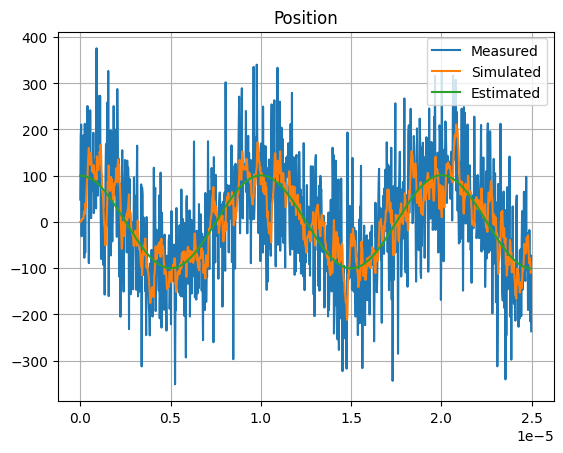

In [95]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t[:1000], measured_states[:1000])
plt.plot(t[:1000], estimated_states[:1000,0])
plt.plot(t[:1000], new_states[:1000,0])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()

In [ ]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:1000], estimated_states[:1000,1])
plt.plot(t[:1000], new_states[:1000,1])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()